# Shufler

I'm attempting to see if there's a correlation between the number of times you have to shuffle a deck of Magic: The Gathering cards, and the qualities of the opening hand you get.

In [22]:
%matplotlib inline

import os

import random
import pickle

import json

import numpy as np
from scipy.stats import multivariate_normal as multinomial
from scipy.stats import rv_discrete
from scipy.stats import norm

import pandas as pd

from matplotlib import pyplot
import seaborn

from jupyterthemes import jtplot

from mtgsdk import Card

jtplot.style('solarizedd')

get_card
--------

A function to return card names from the mtgsdk.

In [2]:
def get_card(card_name):
    '''A function to return card names form the mtgsdk
    
    Arguments:
        card_name - a string containing the name of a card (in any arrangement of case)
        
    Returns:
        card - mtgsdk object containing card information
    
    Excepts:
        None'''
    
    print(f'Retrieving: {card_name.title()}.')
    card = Card.where(name=card_name).all()[0]
    print(f'{card_name.title()} retrieved!\n')
    
    return card

rifle_shuffle
-------------

A rifle shuffle function.

Very simply:

1. Splits the deck into two (potentially uneven) sub-piles.
2. While there are still cards in each pile, alternately drop a random number of cards between 1 and 2 from the bottom of each sub-pile onto the pile.
3. If you run out of cards in either one of the sub-piles, drop the remainder of the other sub-pile on top.
4. Returns the pile to whatever called the function.

In [3]:
def rifle_shuffle(deck_list):
    '''A rifle shuffle function.
    
    Arguments:
        deck_list - a list, but is expected to be something that represents a deck of cards.
        
    Returns:
        pile - a list: the newly shuffled deck.
        
    Excepts:
        None'''
    pile = []
    
    a = [a for a in range(28,33)]
    split = random.choices(a)[0]
    
    half1 = deck_list[:split]
    half2 = deck_list[split:]
    
    d = [a for a in range(1,2)]
    
    while (half1 and half2):
        half1_drop_number_of_cards = random.choices(d)[0]
        half2_drop_number_of_cards = random.choices(d)[0]
        pile = pile + half1[-half1_drop_number_of_cards:]
               + half2[-half2_drop_number_of_cards:]
        half1 = half1[:-half1_drop_number_of_cards]
        half2 = half2[:-half2_drop_number_of_cards]
        
    if half1:
        pile = half1 + pile
        
    if half2:
        pile = half2 + pile
    
    return pile

overhand_shuffle
----------------

Overhand shuffling algorithm.

A bit more complex than the rifle shuffle, because the hand size varies so much, and not entirely randomly.

1. Creates a probability density function (pdf) with a mean of 7 and a covariance of 6 (i.e. it's likely that you'll have a 'drop' packet that usually has 7 cards in it, but that could vary between 1 and about 13 - it's quite arbitrary, I know, but it feels about right)
2. While there are cards in the original deck, create a discrete random variable distribution based on that pdf, and use that to determine the size of the drop.
3. Take a packet the size of the drop and put them on top of the deck that's forming.
4. Keep doing this until you have 7 or fewer cards in your original deck, then drop the remaining on top of the new deck.
5. Return the new deck.

In [4]:
def overhand_shuffle(deck_list):
    '''Overhand shuffling algorithm.
    
    Arguments:
        deck_list - a list, but is expected to be something that represents a deck of cards.
    
    Returns:
        left_hand - the reordered list.
        
    Excepts:
        None'''
    a = [x for x in range(100)]
    
    pdf = multinomial.pdf(a, mean=7, cov=6)
    norm_pdf = [(val/sum(pdf)) for val in pdf]
        
    right_hand = deck_list[:]
    left_hand = []
    
    while len(right_hand) > 7:
        overhand_dist = rv_discrete(a=1, b=len(right_hand), values=(a,norm_pdf))
        drop = overhand_dist.rvs(size=1)[0]
        left_hand = right_hand[:drop] + left_hand
        right_hand = right_hand[drop:]
    left_hand = right_hand + left_hand
    right_hand = []
    
    return left_hand

pile_shuffler
-------------

Pile shuffle algorithm.

Another super simple shuffler:

1. Makes a dictionary containing lists of cards from the supplied deck. These decks contain each 'pile'th card, starting with a list beginning with the 1st card, ending with a list beginning with the 'pile'th card.
2. Each of these lists gets reversed to mimic the 'take from the top' technique of pile shuffling.
3. These small lists are concatenated to produce a deck.
4. Return the deck.

In [5]:
def pile_shuffle(deck_list, piles=6):
    '''A pile shuffling algorithm.
    
    Arguments:
        deck_list - a list, but is expected to be something that represents a deck of cards.
        piles - the number of piles that the list will be separated into during the shuffle.
    
    Returns:
        deck - the shuffled deck.
        
    Excepts:
        None'''
    
    temp = {}
    
    for i in range(piles):
        temp[str(i)] = deck_list[i::piles]
        temp[str(i)].reverse()
        
    keys = temp.keys()
    
    deck = []
    
    for key in keys:
        deck = deck + temp[key]
        
    return deck

create_hand
-----------

Retrieves the top 7 cards, making a dataframe out of them, and returning particular aspects of that dataframe. Perhaps not the cleanest way of doing things within this function, but slightly more readable when it comes to the main script.

In [6]:
def create_hand(deck):
    '''Retrieves a "hand" from the deck, and acquires attributes from it.
    
    Arguments:
        deck - a list, but is expected to be a representation of a deck of cards.
        
    Returns:
        hand - a list of the top 7 items as is.
        hand_types - the card types in hand
        hand_cards - the card names in hand
        hand_qualities - the qualities in hand
    
    Excepts:
        None'''
    
    hand = [item for item in deck[:7]]

    df = make_dataframe(hand)
    
    hand_types = list(df['type'])
        
    hand_cards = list(df['name'])
                
    hand_qualities = []
    
    for item in list(df['quality']):
        if isinstance(item, str):
            hand_qualities.append([item])
        else:
            hand_qualities.append(item)
            
    hand_qualities = set(flatten_list(hand_qualities))
    
    return hand, hand_types, hand_cards, hand_qualities

make_dataframe
--------------

Takes a supplied list, and makes a dataframe out of it, returning that dataframe to the calling function.

In [7]:
def make_dataframe(deck, parameters=['name', 'mana_cost', 'cmc', 'quality', 'type']):
    '''Takes a supplied list, and makes a dataframe out of it.
    
    Arguments:
        deck - a list, but is expected to represent a deck of cards (or subsection thereof).
        parameters - a list of strings, which should contain paramaters that can be retrieved
                     from the objects in deck.
    
    Returns:
        df - a dataframe composed of the cards and parameters supplied.
        
    Excepts:
        None'''
    keys = []
    values = []

    data = []

    for card in deck:
        values = []

        for item in parameters:
            values.append(getattr(card, item))

        data.append(values)

    df = pd.DataFrame(data, columns=parameters)
    
    return df

shuffle_iterator
----------------

The meat of the program.

Takes a deck, the search criteria, number of iterations, and some shuffle parameters, and then shuffles the deck and examines the hand you'd draw until the criteria are met.

In [8]:
def shuffle_iterator(deck, search_criteria, iterations=1000,
            overhand_interval=2, basic_shuffle=False):
    '''Iterates over a provided number of iterations, shuffling until the provided search
    criteria have been found.
    
    Arguments:
        deck - a list, of cards, preferrably
        search_terms - a dictionary containing the search parameter as  key, and the
                       values in that key are the parameter contents that we're
                       interested in.
        iterations - more like a sample size, really
        overhand_interval - the number of times to do a rifle shuffle before performing
                            an overhand shuffle
        basic_shuffle - whether or not to perform a 'basic' shuffle of 5 multiples of
                        (2 rifles shuffles and an overhand shuffle)
        
    Returns:
        stats - a dictionary containing the number of shuffles required to meet the
                criteria in each iteration and the hand in each case.
    
    Except:
        None'''
    
    stats = []
    
    starting_deck = list(deck)

    for i in range(iterations):
        
        if basic_shuffle:
            for i in range(5):
                deck = rifle_shuffle(starting_deck)
                deck = rifle_shuffle(deck)
                deck = overhand_shuffle(deck)
        else:
            deck = list(random.sample(deck, len(deck)))
            
        
        shuffles = 0
        overhand_shuffles = False
        
        hand, hand_types, hand_cards, hand_qualities = create_hand(deck)
        
        while not (search_criteria['quality'].issubset(hand_qualities)
                   and ((hand_types.count('Basic Land — Swamp') == 2) or  #  this is for mana
                        ((hand_cards.count('Urborg, Tomb of Yawgmoth') == 1) and
                         (hand_types.count('Land') == 2)))):
            
            deck = rifle_shuffle(deck)
            
            hand, hand_types, hand_cards, hand_qualities = create_hand(deck)
        
            shuffles = shuffles + 1
            
            if (shuffles % overhand_interval) == 0:
                deck = overhand_shuffle(deck)

        stats.append({'shuffles': shuffles, 'hand': hand})
        
        deck = pile_shuffle(deck)
        
    return stats

flatten_list
------------

Takes a list containing sublists and flattens it.

In [9]:
def flatten_list(list_of_lists):
    '''Takes a list of lists and flattens it.
    
    Arguments:
        list_of_lists - a list of lists.
    
    Returns:
        flat_list - flattened list.
        
    Except:
        None'''
    flat_list = [item for sublist in list_of_lists for item in sublist]
    
    return flat_list

make_list
---------

Takes an item and turns it into a list. For some reason.

In [10]:
def make_list(item):
    '''Takes an item and turns it into a list. For some reason.
    
    Arguments:
        item - int, float, string, whatever.
    
    Returns:
        item - th'''
    if not isinstance(item, list):
        item = [item]
    
    return item

In [11]:
deck_json = 'deck.json'
deck_pickle = 'deck.pkl'

if os.path.isfile(deck_pickle):
    with open(deck_pickle, 'rb') as f:
        deck_list = pickle.load(f)
else:
    with open(deck_json, 'rb') as f:
        card_list = json.load(f)

    cards = {}

    for i in card_list.keys():
        name = card_list[i]['name']
        quantity = card_list[i]['quantity']
        quality = card_list[i]['quality']
        card = get_card(name)
        card.quality = quality
        cards[name] = [card, quantity]

    deck_list = []

    for key in cards.keys():
        for i in range(0,cards[key][1]):
            deck_list.append(cards[key][0])
    with open('deck.pkl', 'wb') as f:
        pickle.dump(deck_list, f)

In [12]:
search_terms = {'quality': {'targetted discard', 
                            'win condition',
                            'recurring'}}

In [13]:
deck_random = list(random.sample(deck_list, len(deck_list)))

stats_random = shuffle_iterator(deck_random, search_terms, iterations=1000)

In [14]:
stats_unshuffled = shuffle_iterator(list(deck_list), search_terms, iterations=1000, basic_shuffle=True)

In [15]:
number_of_shuffles_random = [stat['shuffles'] for stat in stats_random]
number_of_shuffles_unshuffled = [stat['shuffles'] for stat in stats_unshuffled]

Modal number of shuffles is: 0
Average number of shuffles is: 32.827


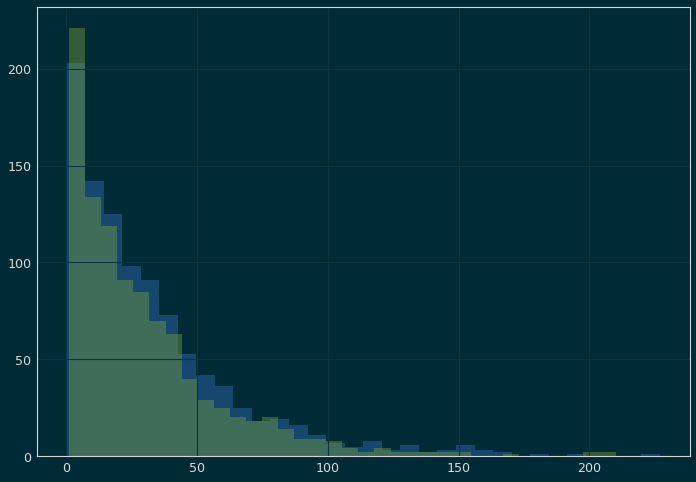

In [23]:
print(f'Modal number of shuffles is: {max(set(number_of_shuffles_random), key=number_of_shuffles_random.count)}')
print(f'Average number of shuffles is: {sum(number_of_shuffles_random)/len(number_of_shuffles_random)}')

q = [number_of_shuffles_random, number_of_shuffles_unshuffled]

b = len(q)

dist = {}

for a in range(b):
    dist[str(a)] = {x:q[a].count(x) for x in q[a]}

a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)

for a in [number_of_shuffles_random, number_of_shuffles_unshuffled]:
    seaborn.distplot(a, ax=ax, kde=False)

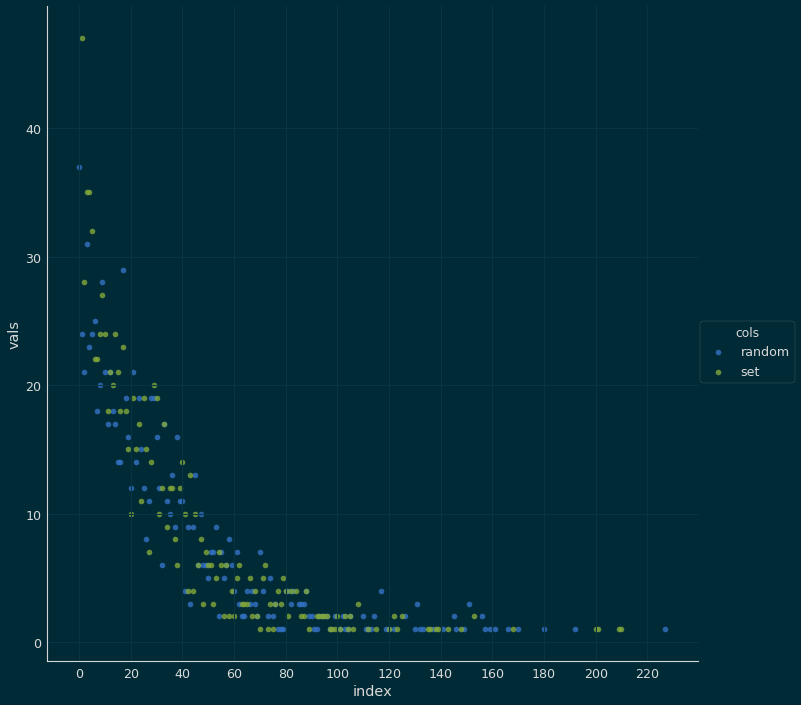

In [24]:
highest_count = max([max(dist[key].keys()) for key in dist.keys()])

data = []

for a in range(b):
    value = []
    index = []
    for i in range(highest_count + 1):
        index.append(i)
        if i in set(dist[str(a)].keys()):
            value.append(dist[str(a)][i])
        else:
            value.append(None)
    
    data.append(value)

test = pd.DataFrame(data, index=['random', 'set']).transpose()

test.reset_index(inplace=True)

test_melt = test.melt('index', var_name='cols', value_name='vals')

g = seaborn.lmplot(x='index', y='vals', hue='cols', 
                   data=test_melt, fit_reg=None,
                   size=10)

g.set(xticks=test['index'][0::20])

In [26]:
test = test.fillna(0.0)

for a in ['random', 'set']:
    test[a + ' cumulative'] = pd.Series([sum(filter(None, test[a][:i])) for i in list(test.index)])

Number of shuffles for random with 50% chance of criteria success: 24

Number of shuffles for set with 50% chance of criteria success: 22



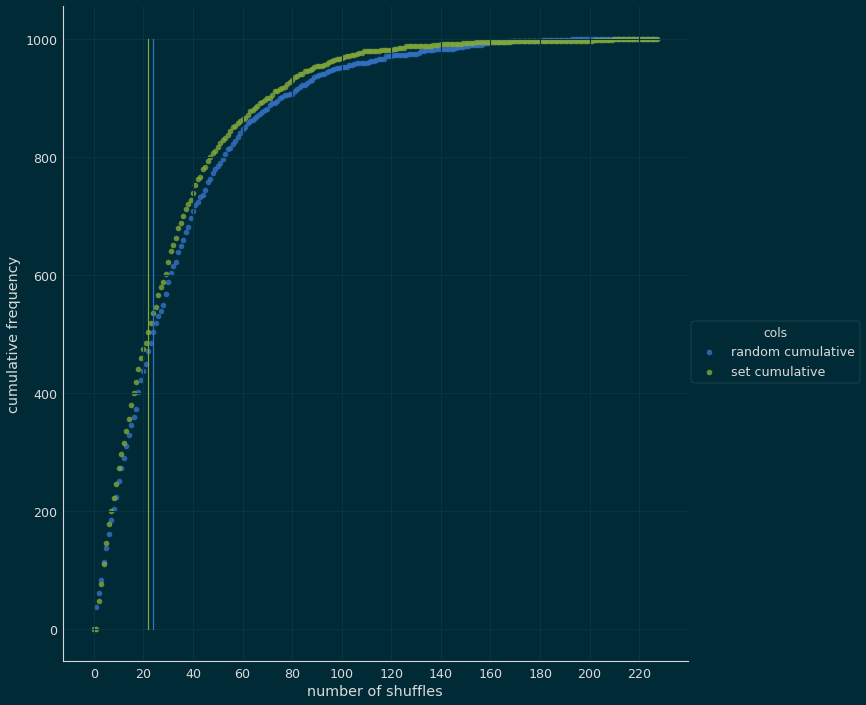

In [27]:
cumulative = test[['index', 'random cumulative', 'set cumulative']]

cumulative_melt = cumulative.melt(id_vars='index',
                                  var_name='cols', value_name='vals')


positions = {}

strings = ['random cumulative', 'set cumulative']

for a in strings:
    positions[a] = cumulative.loc[cumulative[a] >= 500].index[0]

g = seaborn.lmplot(x='index',
                   y='vals', hue='cols',
                   data=cumulative_melt, fit_reg=None,
                   size=10)

g.set(xticks=test['index'][0::20])

g.set(xlabel='number of shuffles', ylabel='cumulative frequency')

for a in positions.keys():
    print(f'Number of shuffles for {a.split()[0]} with 50% chance of criteria success: {positions[a]}\n')
    pyplot.plot([positions[a], positions[a]], [0, 1000])